In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from os.path import join
import pickle
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
from correlate import zero_lag_correlate
from filtering import freq_filt

In [3]:
data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'
with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [4]:
banner_coords = (44.3, -115.233)
url = f'https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2021-12-01&endtime=2022-06-15&latitude={banner_coords[0]}&longitude={banner_coords[1]}&maxradiuskm=30'
df = pd.read_csv(url)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs = 'EPSG:4326')
res = gdf.loc[:, ['time', 'geometry', 'depth', 'mag', 'id']]

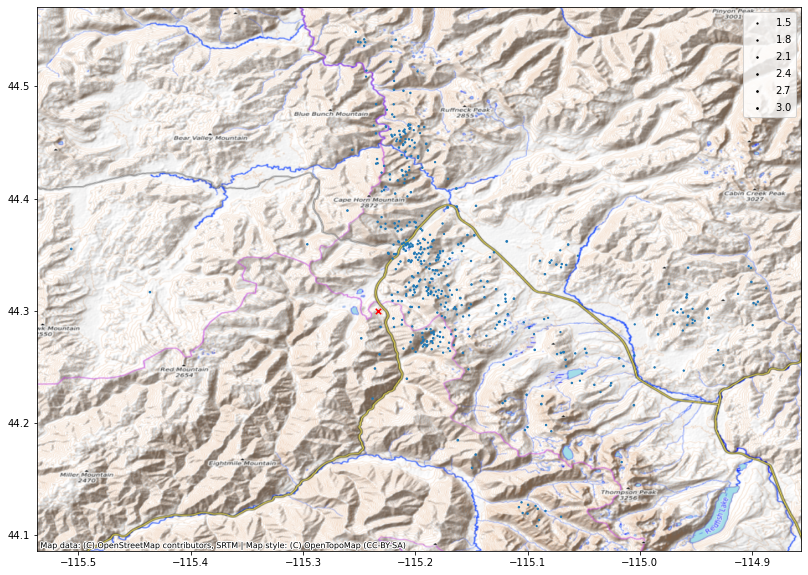

In [4]:
# ax = res.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', markersize = res.mag*15, legend = True)
f, ax = plt.subplots(figsize=(16, 10))
sc = ax.scatter(x = res.geometry.x, y = res.geometry.y, s=res.mag)

ax.scatter(x = banner_coords[1], y = banner_coords[0], s = 30, color = 'red', marker = 'x')
cx.add_basemap(ax, crs = gdf.crs, source = cx.providers.OpenTopoMap)
plt.legend(*sc.legend_elements("sizes", num=6))
plt.show()

In [5]:
# Calculate Distance to Snotel from Source
wgs84 = pyproj.CRS('EPSG:4326')
itm = pyproj.CRS('EPSG:8826') # Idaho Tranvserse Mercator - https://epsg.io/8826
project = pyproj.Transformer.from_crs(wgs84, itm, always_xy=True).transform
wgs_snotel = Point(*banner_coords[::-1])
itm_snotel = transform(project, wgs_snotel)
res_geo = res.to_crs('EPSG:8826')
res.loc[:, 'distance_km'] = res_geo.distance(itm_snotel)/1000 # convert m to km
# Calculate Azimuth
geodesic = pyproj.Geod(ellps='WGS84')
for i,r in res.iterrows():
    fwd_azimuth,_,_ = geodesic.inv(wgs_snotel.x, wgs_snotel.y, r.geometry.x, r.geometry.y)
    res.loc[i, 'azimuth'] = fwd_azimuth

2021-12-18


/bsuhome/zacharykeskinen/infrasound/src/functions/correlate.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return np.einsum('i,i->',A_mA,B_mB)/np.sqrt(ssA*ssB)


2021-12-18
2021-12-17
2021-12-17
0.7708277890515274
16051.283251345845
M2.8 at 11.731964367682892 km away at depth = 7.56 km


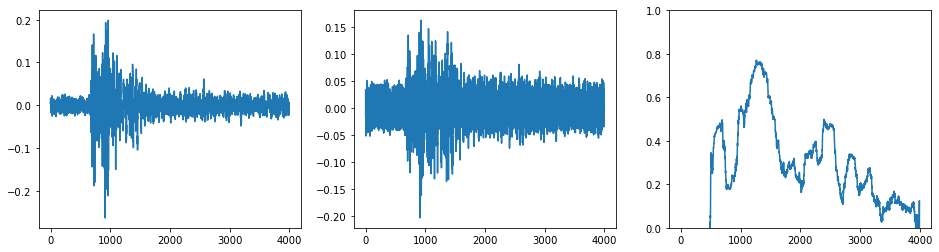

2021-12-16
2021-12-15
2021-12-15
2021-12-15
0.7164714743770794
7383.474070507173
M2.5 at 8.698289031263258 km away at depth = 10.0 km


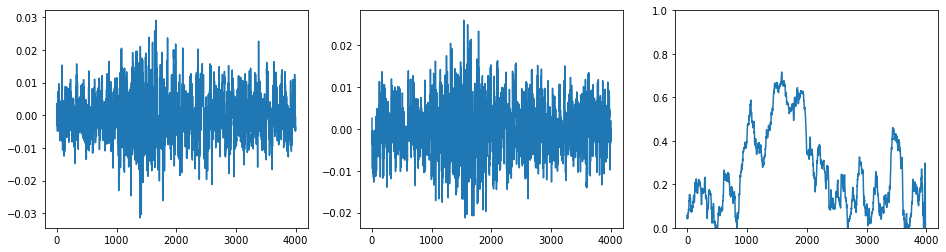

2021-12-14
0.814391527291521
15154.715304529693
M3.1 at 11.429559644165984 km away at depth = 12.37 km


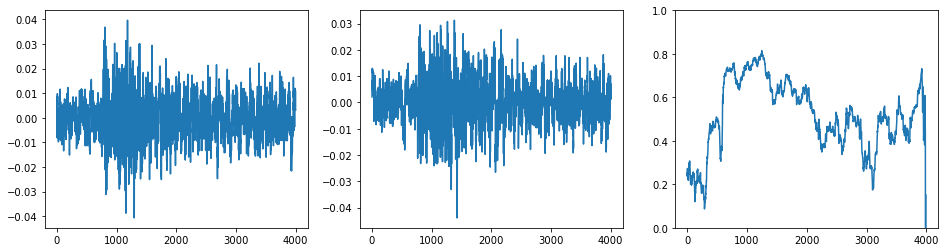

2021-12-14
2021-12-14
0.7564239052589088
2336.3204114714963
M2.7 at 15.0041041205697 km away at depth = 18.64 km


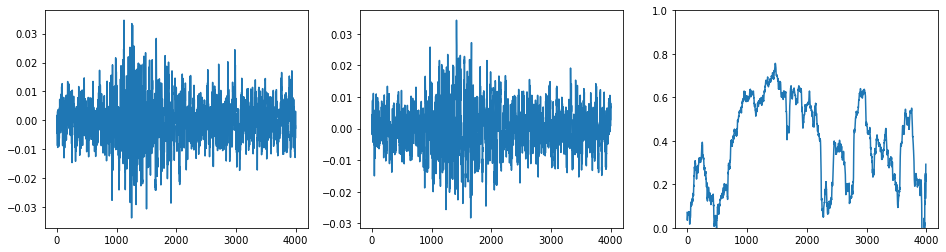

2021-12-14
2021-12-14
0.8298209858248972
4420.905573115421
M3.2 at 10.340635001028826 km away at depth = 23.55 km


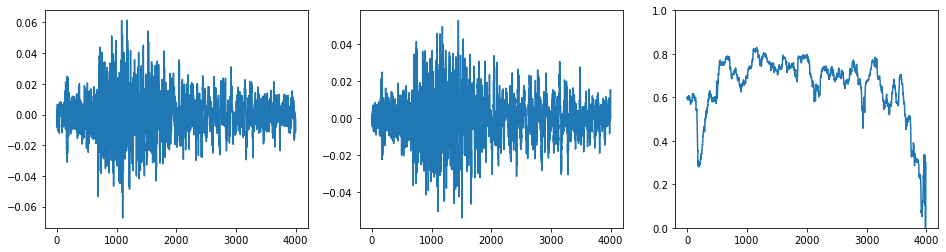

2021-12-14
0.8127799652578733
128165.26328800753
M2.8 at 9.719947728416273 km away at depth = 18.84 km


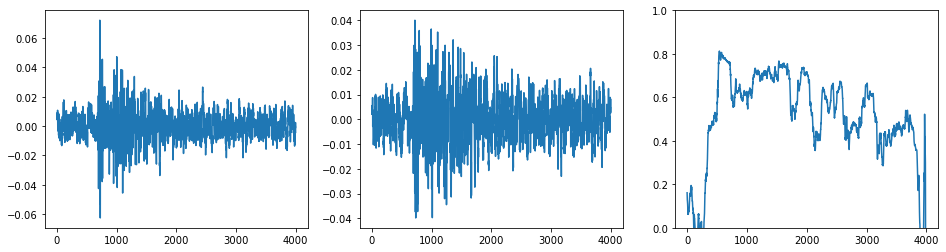

2021-12-12
2021-12-11
2021-12-11
0.8686969703609266
5068.026692746653
M2.27 at 8.700397465796287 km away at depth = 6.1 km


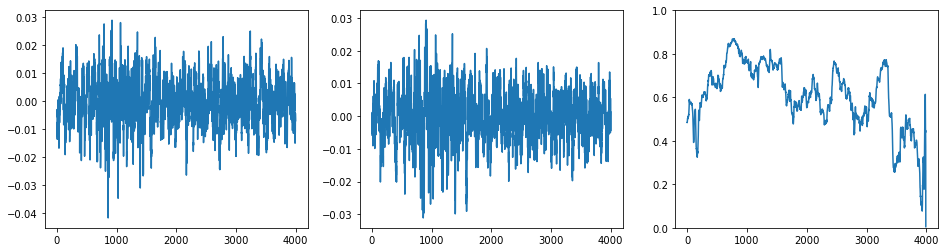

2021-12-11
2021-12-11
0.785445764510064
4274.204953494454
M2.4 at 17.29227977193109 km away at depth = 10.0 km


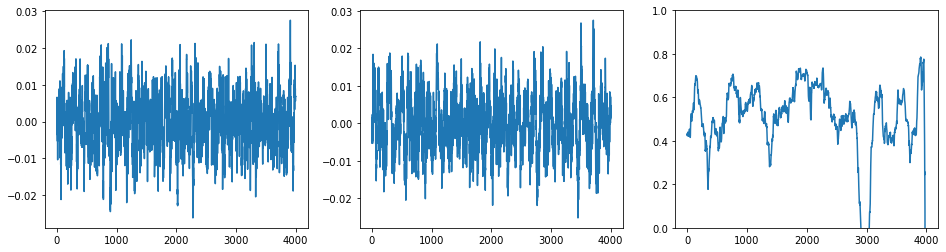

2021-12-10
2021-12-10
2021-12-10
2021-12-09
0.9135905883748628
22873.315216827505
M2.5 at 17.87032298808516 km away at depth = 10.0 km


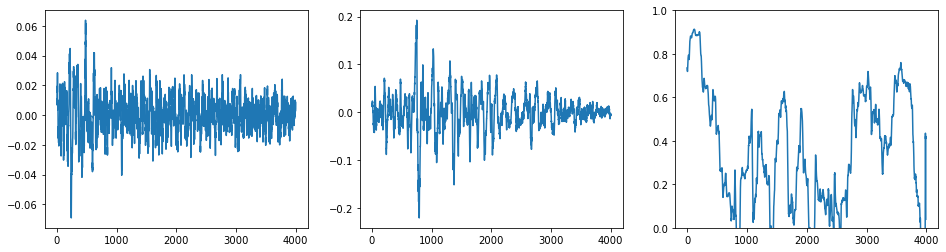

2021-12-09
2021-12-09
2021-12-08
2021-12-08
2021-12-07
2021-12-07
2021-12-07
2021-12-05
2021-12-05
2021-12-03
0.5879416618460727
2073.197772487494
M1.72 at 23.63965330756722 km away at depth = 5.58 km


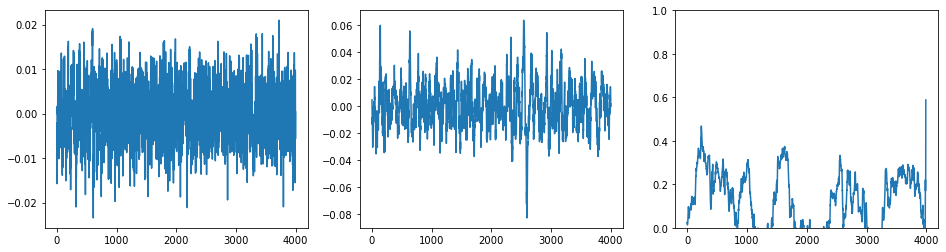

2021-12-03
2021-12-02
2021-12-02
2021-12-02
2021-12-01


In [12]:
for i, r in res.iterrows():
    if i > 430:
        dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
        print(dt)
        if dt in days.keys():
            day = days[dt]
            if 0.33 in day.keys():
                s = pd.to_datetime(r.time)
                ps = s - pd.Timedelta('10 seconds') 
                e = s+ pd.Timedelta('20 seconds')
                d = {}
                d['lower'] = pd.read_parquet(day[0.33])
                pre_mean = np.nanmean(d['lower'].loc[s:e, :].values.ravel())
                d['upper'] = pd.read_parquet(day[1])
                try:
                    for i, k in enumerate(d.keys()):
                        d[k] = d[k].loc[s:e, :].values.ravel()
                        d[k] = freq_filt(d[k], fc = 1, kind = 'highpass', sps = sps)
                    corr = zero_lag_correlate(d['lower'], d['upper'], 1)[:-10]
                    max_ratio = np.abs(np.nanmax(d['lower'])/pre_mean)
                    mean_ratio = np.abs(np.nanmean(d['lower'])/pre_mean)
                    if np.nanmax(corr) >0.5 and mean_ratio > 2000:
                        print(np.nanmax(corr))
                        print(f'max ratio: {max_ratio}. mean ratio: {mean_ratio}')
                        f, axes = plt.subplots(1,3, figsize = (16,4))
                        print(f'M{r.mag} at {r.distance_km} km away at depth = {r.depth} km')
                        axes[0].plot(d['lower'])
                        axes[1].plot(d['upper'])
                        axes[2].plot(corr)
                        axes[2].set_ylim(0, 1.0)
                        plt.show()
                except ValueError:
                    pass